In [1]:
import pandas as pd
import numpy as np
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import pymc as pm
import arviz as az
import pandas as pd
import scipy.linalg as la
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import nltk
from nltk.corpus import stopwords
import json
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
az.style.use('arviz-darkgrid')
os.chdir('/Users/noahdunn/Desktop/MSDS/DS6040/Project')

WARNING (aesara.configdefaults): g++ not detected!  Aesara will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set Aesara flags cxx to an empty string.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
df = pd.read_csv('Use_This.csv')

In [3]:
df.head()

,Unnamed: 0,game_id,player_id,starter,mp,did_not_play,is_inactive,fantasy_points,player_name,position,team,opponent,teamscore,opponentscore,date,avg_pts
0,5038,202101200TOR,achiupr01,0,14:24,0,0,12.8,Precious Achiuwa,F,TOR,MIA,102,111,120,12.800000
1,5560,202101220TOR,achiupr01,0,11:32,0,0,10.7,Precious Achiuwa,F,TOR,MIA,101,81,122,12.800000
2,14277,202102240MIA,achiupr01,0,6:00,0,0,3.4,Precious Achiuwa,F,TOR,MIA,108,116,224,11.750000
3,42496,202110200TOR,achiupr01,1,18:30,0,0,18.4,Precious Achiuwa,F,TOR,WAS,83,98,1020,8.966667
4,42647,202110220BOS,achiupr01,1,24:50,0,0,35.0,Precious Achiuwa,F,TOR,BOS,115,83,1022,11.325000


In [11]:

# Conditions
conditions = [
    (df['fantasy_points'] <= 0) & (df['avg_pts'] < 2),
    (df['fantasy_points'] > 0) & (df['fantasy_points'] < 3.3) & (df['avg_pts'] >= 2) & (df['avg_pts'] < 6.5),
    (df['fantasy_points'] >= 3.3) & (df['fantasy_points'] < 15.6) & (df['avg_pts'] >= 6.5) & (df['avg_pts'] < 16),
    (df['fantasy_points'] >= 15.6) & (df['fantasy_points'] < 27.5) & (df['avg_pts'] >= 16) & (df['avg_pts'] < 25), 
    (df['fantasy_points'] >= 27.5) & (df['fantasy_points'] < 100) & (df['avg_pts'] >= 25) & (df['avg_pts'] < 73)]

# Ranks
values = [0, 1, 2, 3, 4]

# Assign
df['rank'] = np.select(conditions, values)

# Testing out his Hierarchical Stuff

# Predictor variables
minutes = df['mp']
# normal
points = df['fantasy_points']
# normal
opponent = df['opponent']
# 
avgpoints = df['avg_pts']
# normal (as prior on points?)
starter = df['starter']
# bernoulli

# grouping or hierarchical variable
positions = df['position'].unique()
npositions = len(positions)

# lookup table (dict) for each district
position_lookup = dict(zip(positions, range(npositions)))
position  = df["position_code"] = df.position.replace(position_lookup).values

In [12]:
# Predictor variables
minutes = df['mp']
# normal
points = df['fantasy_points']
# normal
opponent = df['opponent']
# 
avgpoints = df['avg_pts']
# normal
starter = df['starter']
# bernoulli

rank = df['rank']
# 

# grouping or hierarchical variable
positions = df['position'].unique()
npositions = len(positions)

# lookup table (dict) for each district
position_lookup = dict(zip(positions, range(npositions)))
position  = df["position_code"] = df.position.replace(position_lookup).values

In [13]:
test = []
for i in minutes:
    j = i.split(':')
    secs = int(j[1])
    if secs > 30:
        ans = int(j[0])
    else:
        ans = int(j[0]) + 1
    test.append(ans)

In [14]:
test2 = pd.factorize(df['opponent'])[0]+1

with pm.Model() as hierarchical_model:

    # Priors for the model parameters
    # Gaussians for the means of the priors of the random intercepts and slopes
    mu_a = pm.Normal('mu_a', mu=0., sigma=1e5)
    mu_b = pm.Normal('mu_b', mu=0., sigma=1e5)
    mu_c = pm.Normal('mu_c', mu=0., sigma=1e5)
    mu_d = pm.Normal('mu_d', mu=0., sigma=1e5)
    mu_e = pm.Normal('mu_e', mu=0., sigma=1e5)
    
    # Half-Cauchy for the standard deviations of the priors 
    # of the random intercepts and slopes
    sigma_a =  pm.HalfCauchy('sigma_a', 1e5)
    sigma_b =  pm.HalfCauchy('sigma_b', 1e5)
    sigma_c =  pm.HalfCauchy('sigma_c', 1e5)
    sigma_d =  pm.HalfCauchy('sigma_d', 1e5)
    sigma_e =  pm.HalfCauchy('sigma_e', 1e5)

    # Gaussian priors for random intercepts and slopes
    a = pm.Normal('a', mu=mu_a, sigma=sigma_a, shape=npositions)
    b = pm.Normal('b', mu=mu_b, sigma=sigma_b, shape=npositions)
    c = pm.Normal('c', mu=mu_c, sigma=sigma_c, shape=npositions)
    d = pm.Normal('d', mu=mu_d, sigma=sigma_d, shape=npositions)
    e = pm.Normal('e', mu=mu_e, sigma=sigma_e, shape=npositions)
    
    # Linear model
    μ = a[position] + b[position]*test + c[position]*test2 + d[position]*avgpoints + e[position]*starter
    
    # Transform outcome to probability
    #θ = pm.Deterministic('θ', pm.invlogit(μ))
    #y_hat = pm.Bernoulli('y_hat', p=θ, observed=points)
    mu_x = pm.Normal('mu_x', mu=0., sigma=1e5)
    sigma_x =  pm.HalfCauchy('sigma_x', 1e5)
    y_hat = pm.Normal('y_hat', mu=mu_x, sigma=sigma_x, observed=points)
    
    
    # Sample the posterior
    hierarchical_trace = pm.sample(draws=200, step=pm.NUTS(target_accept=0.97), tune=500)

In [ ]:
with pm.Model() as hierarchical_model:

    # Priors for the model parameters
    # Gaussians for the means of the priors of the random intercepts and slopes
    mu_a = pm.Normal('mu_a', mu=0., sigma=1e5)
    mu_c = pm.Normal('mu_c', mu=0., sigma=1e5)
    mu_d = pm.Normal('mu_d', mu=0., sigma=1e5)
    mu_e = pm.Normal('mu_e', mu=0., sigma=1e5)
    mu_f = pm.Normal('mu_f', mu=0., sigma=1e5)
    
    # Half-Cauchy for the standard deviations of the priors 
    # of the random intercepts and slopes
    sigma_a =  pm.HalfCauchy('sigma_a', 1e5)
    sigma_c =  pm.HalfCauchy('sigma_c', 1e5)
    sigma_d =  pm.HalfCauchy('sigma_d', 1e5)
    sigma_e =  pm.HalfCauchy('sigma_e', 1e5)
    sigma_f = pm.HalfCauchy('sigma_f', 1e5)
    

    # Gaussian priors for random intercepts and slopes
    a = pm.Normal('a', mu=mu_a, sigma=sigma_a, shape=npositions)
    
    c = pm.Normal('c', mu=mu_c, sigma=sigma_c, shape=npositions)
    d = pm.Normal('d', mu=mu_d, sigma=sigma_d, shape=npositions)
    e = pm.Normal('e', mu=mu_e, sigma=sigma_e, shape=npositions)
    f = pm.Normal('f', mu=mu_f, sigma=sigma_f, shape=npositions)
    
    # Linear model
    μ = a[position] + c[position]*test2 + e[position]*starter + f[position]*rank
    
    # Transform outcome to probability
    #θ = pm.Deterministic('θ', pm.invlogit(μ))
    #y_hat = pm.Bernoulli('y_hat', p=θ, observed=points)
    mu_x = pm.Normal('mu_x', mu=0., sigma=1e5)
    sigma_x =  pm.HalfCauchy('sigma_x', 1e5)
    y_hat = pm.Normal('y_hat', mu=mu_d, sigma=sigma_d, observed=points)
    
    
    # Sample the posterior
    hierarchical_trace = pm.sample(draws=250, step=pm.NUTS(target_accept=0.99), tune=500)


In [21]:
# Variational inference with ADVI optimization
advi_hierarchical_fit = pm.fit(500, method='advi', model = hierarchical_model)

Finished [100%]: Average Loss = 3.8131e+05


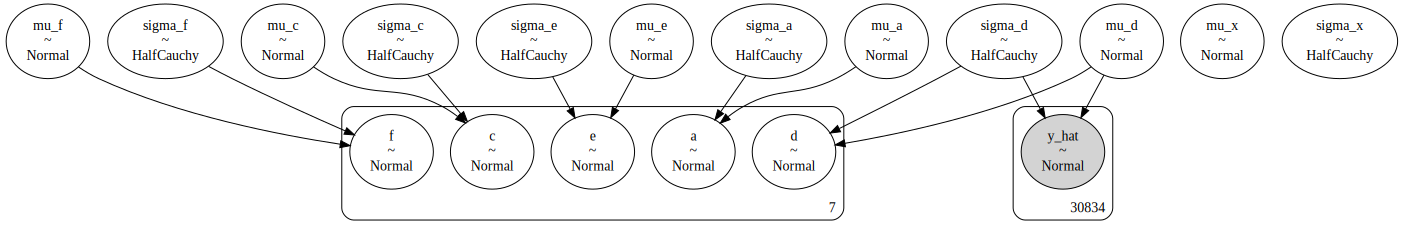

In [22]:
# Graph the hierarchical model
pm.model_to_graphviz(hierarchical_model)

In [23]:
az.plot_trace(hierarchical_trace, var_names=['a','b','c','d','e'],compact =True)

NameError: name 'hierarchical_trace' is not defined

In [ ]:
# plot the ELBO vs. fitting time or iterations (n)
advi_elbo = pd.DataFrame(
    {'ELBO': -advi_hierarchical_fit.hist,
     'n': np.arange(advi_hierarchical_fit.hist.shape[0])})

plt.figure(dpi=100)
ax = sns.lineplot(y='ELBO', x='n', data=advi_elbo)
ax.set_title("ELBO vs. time")
plt.show()

In [ ]:
# sample from the variational posterior distribution
PPC_SAMPLES = 5000
advi_hierarchical_sample = advi_hierarchical_fit.sample(PPC_SAMPLES)

# Comparison of Variational and Sampling methods 
# Parameter posteriors in a forest plot

f, (ax1, ax2) = plt.subplots(1, 2, sharey=False, figsize = (14,20))

pm.plot_forest(advi_hierarchical_sample, var_names=['a'], ax = ax1)
pm.plot_forest(hierarchical_trace, var_names=['a'], ax = ax2)
ax1.set_title('Variational 94% HDI')
ax2.set_title('Sampling 94% HDI')

In [ ]:
# Comparison of Variational and Sampling methods 
# Parameter posteriors in a forest plot

f, (ax1, ax2) = plt.subplots(1, 2, sharey=False, figsize = (14,20))

pm.plot_forest(advi_hierarchical_sample, var_names=['b'], ax = ax1)
pm.plot_forest(hierarchical_trace, var_names=['b'], ax = ax2)
ax1.set_title('Variational 94% HDI')
ax2.set_title('Sampling 94% HDI')

/var/folders/zv/dgpjcyt11wq_46q7rsj9q_280000gn/T/ipykernel_66328/167690253.py:20: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout()


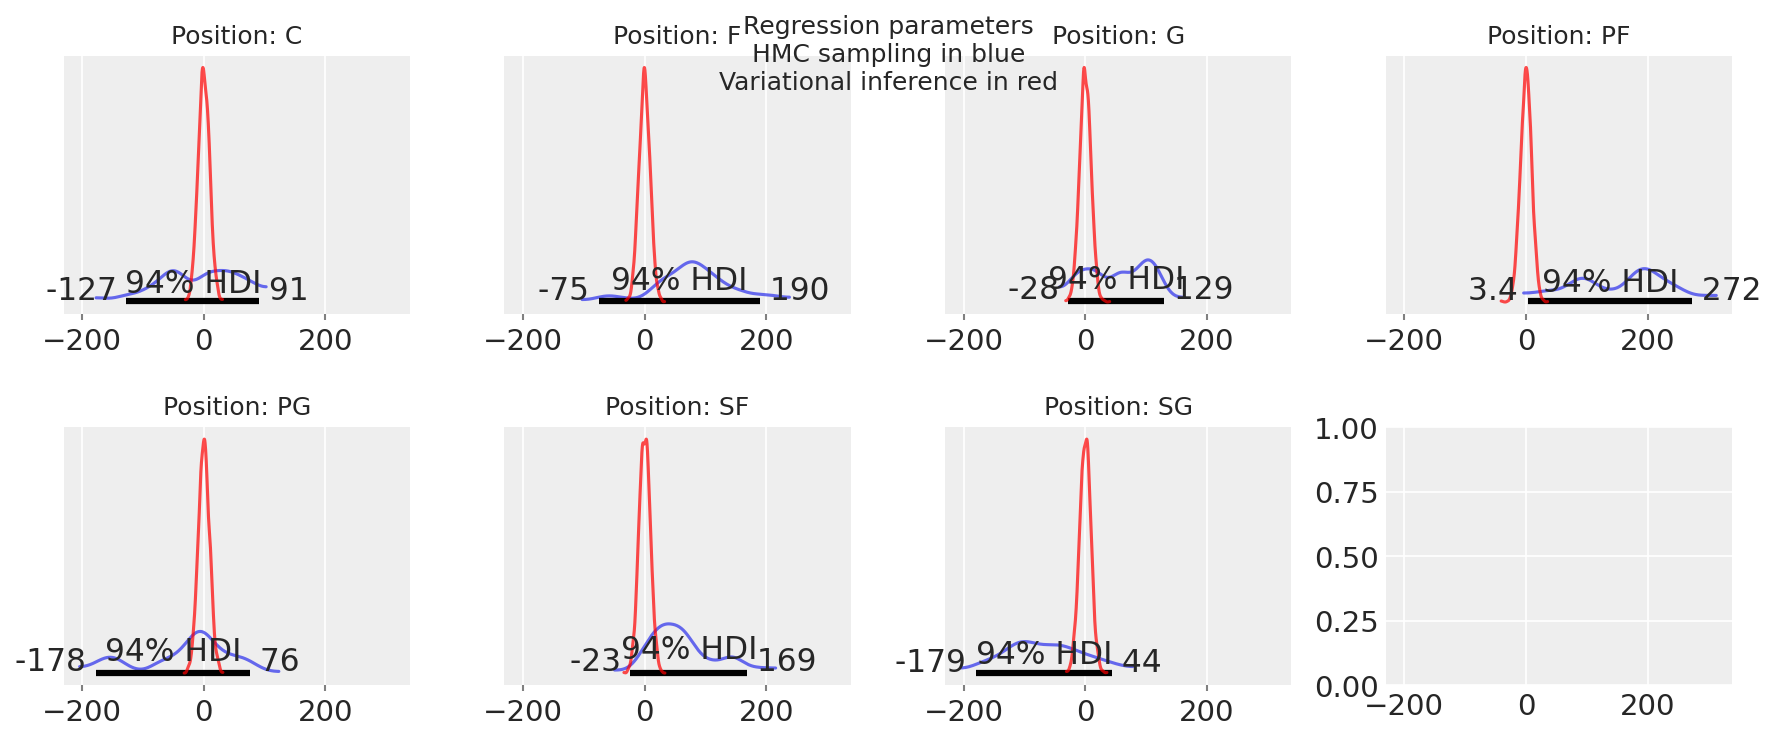

In [52]:
# Comparison Plots for intercepts

#burnin = 100

sample_intercept = hierarchical_trace.posterior['a'].mean(axis =0)
advi_intercept = advi_hierarchical_sample.posterior['a']


# Plot parameter posterior distributions


fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(12, 5), dpi=150, sharex=True)

for i, ax, level in zip(range(npositions), axes.ravel(), sorted(positions)):
    pm.plot_posterior(sample_intercept[:,i], ax=ax, point_estimate=None,  alpha=0.7)
    pm.plot_posterior(advi_intercept[0,:,i], ax=ax, color='red', point_estimate=None, hdi_prob= 'hide', alpha=0.7)
    ax.set_title("Position: " + str(level), fontsize=12)
    
plt.suptitle("Regression parameters\nHMC sampling in blue\nVariational inference in red")
plt.tight_layout()
plt.subplots_adjust(top=0.925)
plt.show()

In [47]:
df

,Unnamed: 0,game_id,player_id,starter,mp,did_not_play,is_inactive,fantasy_points,player_name,position,...,opponent,teamscore,opponentscore,date,avg_pts,position_code,rank,diff_from_avg,test2,test3
0,5038,202101200TOR,achiupr01,0,14:24,0,0,12.8,Precious Achiuwa,F,...,MIA,102,111,120,12.800000,0,2,0.000000,1,1
1,5560,202101220TOR,achiupr01,0,11:32,0,0,10.7,Precious Achiuwa,F,...,MIA,101,81,122,12.800000,0,2,-2.100000,1,1
2,14277,202102240MIA,achiupr01,0,6:00,0,0,3.4,Precious Achiuwa,F,...,MIA,108,116,224,11.750000,0,2,-8.350000,1,1
3,42496,202110200TOR,achiupr01,1,18:30,0,0,18.4,Precious Achiuwa,F,...,WAS,83,98,1020,8.966667,0,0,9.433333,2,1
4,42647,202110220BOS,achiupr01,1,24:50,0,0,35.0,Precious Achiuwa,F,...,BOS,115,83,1022,11.325000,0,0,23.675000,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30829,53979,202112200LAC,zubaciv01,1,27:21,0,0,31.9,Ivica Zubac,C,...,SAS,92,116,1220,20.970000,1,0,10.930000,29,21
30830,54290,202112220SAC,zubaciv01,1,26:39,0,0,22.2,Ivica Zubac,C,...,SAC,105,89,1222,23.180000,1,3,-0.980000,12,21
30831,54770,202112260LAC,zubaciv01,1,27:22,0,0,36.2,Ivica Zubac,C,...,DEN,100,103,1226,22.760000,1,0,13.440000,20,21
30832,54968,202112270LAC,zubaciv01,1,21:45,0,0,19.3,Ivica Zubac,C,...,BRK,108,124,1227,24.130000,1,3,-4.830000,10,21


# Restarting

In [29]:
df['diff_from_avg'] = df['fantasy_points'] - df['avg_pts']

In [41]:
df['test2'] = pd.factorize(df['opponent'])[0]+1
df['test3'] = pd.factorize(df['team'])[0]+1

In [42]:
one_hot_df = pd.get_dummies(df,columns=['position'])
one_hot_df.head()

,Unnamed: 0,game_id,player_id,starter,mp,did_not_play,is_inactive,fantasy_points,player_name,team,...,diff_from_avg,test2,test3,position_C,position_F,position_G,position_PF,position_PG,position_SF,position_SG
0,5038,202101200TOR,achiupr01,0,14:24,0,0,12.8,Precious Achiuwa,TOR,...,0.000000,1,1,0,1,0,0,0,0,0
1,5560,202101220TOR,achiupr01,0,11:32,0,0,10.7,Precious Achiuwa,TOR,...,-2.100000,1,1,0,1,0,0,0,0,0
2,14277,202102240MIA,achiupr01,0,6:00,0,0,3.4,Precious Achiuwa,TOR,...,-8.350000,1,1,0,1,0,0,0,0,0
3,42496,202110200TOR,achiupr01,1,18:30,0,0,18.4,Precious Achiuwa,TOR,...,9.433333,2,1,0,1,0,0,0,0,0
4,42647,202110220BOS,achiupr01,1,24:50,0,0,35.0,Precious Achiuwa,TOR,...,23.675000,3,1,0,1,0,0,0,0,0


import theano

num_positions=7
ranks=5
team_number = len(df['team'].unique())
np.random.seed(182)
train = one_hot_df

with pm.Model() as mdl:
    nu = pm.Exponential('nu minus one', 1/29.,shape=2) + 1 # from https://pymc-devs.github.io/pymc3/notebooks/BEST.html
    err = pm.Uniform('std dev based on rank', 0, 100, shape=ranks)
    err_b = pm.Uniform('std dev based on rank b', 0, 100, shape=ranks)

    # Theano shared variables to change at test time
    #player_home = theano.shared(np.asarray(train['is_home'].values, dtype = int))
    player_avg = theano.shared(np.asarray((train['avg_pts']).values, dtype = float))
    player_opp = theano.shared(np.asarray((train['test3']).values, dtype = int))
    player_team = theano.shared(np.asarray((train['test2']).values, dtype = int))
    player_rank = theano.shared(np.asarray((train['rank']).values, dtype = int))
    C = theano.shared(np.asarray((train['position_C']).values.astype(int), dtype = int))
    F = theano.shared(np.asarray((train['position_F']).values.astype(int), dtype = int))
    G = theano.shared(np.asarray((train['position_G']).values.astype(int), dtype = int))
    PF = theano.shared(np.asarray((train['position_PF']).values.astype(int), dtype = int))
    PG = theano.shared(np.asarray((train['position_PG']).values.astype(int), dtype = int))
    SF = theano.shared(np.asarray((train['position_SF']).values.astype(int), dtype = int))
    SG = theano.shared(np.asarray((train['position_SG']).values.astype(int), dtype = int))
    #pos_id = theano.shared(np.asarray((train['pos_code']).values, dtype = int))
    
    # Defensive ability of the opposing team vs. each position, partially pooled
    opp_def = pm.Normal('opp team prior',0, sigma=100**2, shape=num_positions)
    opp_C = pm.Normal('defensive differential c', opp_def[0], sigma=100**2, shape=team_number)
    opp_F = pm.Normal('defensive differential f', opp_def[1], sigma=100**2, shape=team_number)
    opp_G = pm.Normal('defensive differential g', opp_def[2], sigma=100**2, shape=team_number)
    opp_PF = pm.Normal('defensive differential pf', opp_def[3], sigma=100**2, shape=team_number)
    opp_PG = pm.Normal('defensive differential pg', opp_def[4], sigma=100**2, shape=team_number)
    opp_SF = pm.Normal('defensive differential sf', opp_def[5], sigma=100**2, shape=team_number)
    opp_SG = pm.Normal('defensive differential sg', opp_def[6], sigma=100**2, shape=team_number)
    
    # Partially pooled ability of the player's rank partially pooled based on position
    home_adv = pm.Normal('home additivie prior', 0, 100**2,shape = num_positions)     
    away_adv = pm.Normal('away additivie prior', 0, 100**2,shape = num_positions)     
    pos_home_C = pm.Normal('home differential c',home_adv[0],10**2, shape = ranks)
    pos_home_F = pm.Normal('home differential f',home_adv[1],10**2, shape = ranks)
    pos_home_G = pm.Normal('home differential g',home_adv[2],10**2, shape = ranks)
    pos_home_PF = pm.Normal('home differential pf',home_adv[3],10**2, shape = ranks)
    pos_home_PG = pm.Normal('home differential pg',home_adv[4],10**2, shape = ranks)
    pos_home_SF = pm.Normal('home differential sf',home_adv[5],10**2, shape = ranks)
    pos_home_SG = pm.Normal('home differential sg',home_adv[6],10**2, shape = ranks)
    
    pos_away_C = pm.Normal('away differential c',away_adv[0],10**2, shape = ranks)
    pos_away_F = pm.Normal('away differential f',away_adv[1],10**2, shape = ranks)
    pos_away_G = pm.Normal('away differential g',away_adv[2],10**2, shape = ranks)
    pos_away_PF = pm.Normal('away differential pf',away_adv[3],10**2, shape = ranks)
    pos_away_PG = pm.Normal('away differential pg',away_adv[4],10**2, shape = ranks)
    pos_away_SF = pm.Normal('away differential sf',away_adv[5],10**2, shape = ranks)
    pos_away_SG = pm.Normal('away differential sg',away_adv[6],10**2, shape = ranks)
    
    # First likelihood where the player's difference from average is explained by defensive abililty
    def_effect = C*opp_C[player_opp]+ F*opp_F[player_opp]+ G*opp_G[player_opp]+ PF*opp_PF[player_opp]+ PG*opp_PG[player_opp]+ SF*opp_SF[player_opp]+ SG*opp_SG[player_opp]
    like1 = pm.StudentT('Diff From Avg', mu=def_effect, sigma=err_b[player_rank],nu=nu[1], observed = train['diff_from_avg'])
    
    # Second likelihood where the score is predicted by defensive power plus other smaller factors
    #mu = player_avg + def_effect
    #mu += rb*pos_home_rb[player_rank]*(player_home) + wr*pos_home_wr[player_rank]*(player_home) 
    #mu += qb*pos_home_qb[player_rank]*(player_home) + te*pos_home_te[player_rank]*(player_home) 
    #mu += rb*pos_away_rb[player_rank]*(1-player_home) + wr*pos_away_wr[player_rank]*(1-player_home) 
    #mu += qb*pos_away_qb[player_rank]*(1-player_home) + te*pos_away_te[player_rank]*(1-player_home) 
    #like2 = pm.StudentT('Score', mu=mu, sd=err[player_rank], nu=nu[0], observed=train['score'])

    # Training!
    hierarchical_trace = pm.sample(draws=1000, step=pm.NUTS(target_accept=0.99), tune=1000)


# Team Effect on Position

with pm.Model() as hierarchical_model:

    # Priors for the model parameters
    # Gaussians for the means of the priors of the random intercepts and slopes
    mu_a = pm.Normal('mu_a', mu=0., sigma=1e5)
    mu_c = pm.Normal('mu_c', mu=0., sigma=1e5)
    mu_d = pm.Normal('mu_d', mu=0., sigma=1e5)
    mu_e = pm.Normal('mu_e', mu=0., sigma=1e5)
    mu_f = pm.Normal('mu_f', mu=0., sigma=1e5)
    
    # Half-Cauchy for the standard deviations of the priors 
    # of the random intercepts and slopes
    sigma_a =  pm.HalfCauchy('sigma_a', 1e5)
    sigma_c =  pm.HalfCauchy('sigma_c', 1e5)
    sigma_d =  pm.HalfCauchy('sigma_d', 1e5)
    sigma_e =  pm.HalfCauchy('sigma_e', 1e5)
    sigma_f = pm.HalfCauchy('sigma_f', 1e5)
    

    # Gaussian priors for random intercepts and slopes
    a = pm.Normal('a', mu=mu_a, sigma=sigma_a, shape=npositions)
    
    c = pm.Normal('c', mu=mu_c, sigma=sigma_c, shape=npositions)
    d = pm.Normal('d', mu=mu_d, sigma=sigma_d, shape=npositions)
    e = pm.Normal('e', mu=mu_e, sigma=sigma_e, shape=npositions)
    f = pm.Normal('f', mu=mu_f, sigma=sigma_f, shape=npositions)
    
    # Linear model
    μ = a[position] + c[position]*test2 + e[position]*starter + f[position]*rank
    
    # Transform outcome to probability
    #θ = pm.Deterministic('θ', pm.invlogit(μ))
    #y_hat = pm.Bernoulli('y_hat', p=θ, observed=points)
    mu_x = pm.Normal('mu_x', mu=0., sigma=1e5)
    sigma_x =  pm.HalfCauchy('sigma_x', 1e5)
    y_hat = pm.Normal('y_hat', mu=mu_d, sigma=sigma_d, observed=points)
    
    
    # Sample the posterior
    hierarchical_trace = pm.sample(draws=250, step=pm.NUTS(target_accept=0.99), tune=500)

In [57]:
with pm.Model() as model:
    
    # Priors for the model parameters
    # Gaussians for the means of the priors of the random intercepts and slopes
    mu_a = pm.Normal('mu_a', mu=0., sigma=1e5)
    mu_c = pm.Normal('mu_c', mu=0., sigma=1e5)
    mu_d = pm.Normal('mu_d', mu=0., sigma=1e5)
    mu_e = pm.Normal('mu_e', mu=0., sigma=1e5)
    mu_f = pm.Normal('mu_f', mu=0., sigma=1e5)
    
    # Half-Cauchy for the standard deviations of the priors 
    # of the random intercepts and slopes
    sigma_a =  pm.HalfCauchy('sigma_a', 1e5)
    sigma_c =  pm.HalfCauchy('sigma_c', 1e5)
    sigma_d =  pm.HalfCauchy('sigma_d', 1e5)
    sigma_e =  pm.HalfCauchy('sigma_e', 1e5)
    sigma_f = pm.HalfCauchy('sigma_f', 1e5)
    

    # Gaussian priors for random intercepts and slopes
    a = pm.Normal('a', mu=mu_a, sigma=sigma_a, shape=npositions)
    
    c = pm.Normal('c', mu=mu_c, sigma=sigma_c, shape=npositions)
    d = pm.Normal('d', mu=mu_d, sigma=sigma_d, shape=npositions)
    e = pm.Normal('e', mu=mu_e, sigma=sigma_e, shape=npositions)
    f = pm.Normal('f', mu=mu_f, sigma=sigma_f, shape=npositions)
    
    mu_x = pm.Normal('mu_x', mu=0., sigma=1e5)
    sigma_x =  pm.HalfCauchy('sigma_x', 1e5)

    # Define likelihood
    μ = a[position] + c[position]*test2 + e[position]*starter + f[position]*rank
    likelihood = pm.Normal("y", mu=μ, sigma=sigma_x, observed=points)

    # Inference!
    # draw 3000 posterior samples using NUTS sampling
    #idata = pm.sample(3000)
    idraw = pm.sample(draws=250, step=pm.NUTS(target_accept=0.99), tune=500)

Only 250 samples in chain.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_a, mu_c, mu_d, mu_e, mu_f, sigma_a, sigma_c, sigma_d, sigma_e, sigma_f, a, c, d, e, f, mu_x, sigma_x]
WARNING (aesara.configdefaults): g++ not detected!  Aesara will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set Aesara flags cxx to an empty string.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (aesara.configdefaults): g++ not detected!  Aesara will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set Aesara flags cxx to an empty string.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (aesara.configdefaults): g++ not detected!  Aesara will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To 

/Users/noahdunn/opt/anaconda3/lib/python3.9/site-packages/aesara/scalar/basic.py:1996: RuntimeWarning: overflow encountered in true_divide
  return x / y
/Users/noahdunn/opt/anaconda3/lib/python3.9/site-packages/aesara/scalar/basic.py:1996: RuntimeWarning: overflow encountered in true_divide
  return x / y
/Users/noahdunn/opt/anaconda3/lib/python3.9/site-packages/aesara/scalar/basic.py:1996: RuntimeWarning: overflow encountered in true_divide
  return x / y
/Users/noahdunn/opt/anaconda3/lib/python3.9/site-packages/aesara/scalar/basic.py:1996: RuntimeWarning: overflow encountered in true_divide
  return x / y
/Users/noahdunn/opt/anaconda3/lib/python3.9/site-packages/aesara/tensor/elemwise.py:788: RuntimeWarning: overflow encountered in impl (vectorized)
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
/Users/noahdunn/opt/anaconda3/lib/python3.9/site-packages/aesara/tensor/elemwise.py:788: RuntimeWarning: overflow encountered in impl (vectorized)
  variables = ufunc(*ufunc_args, **ufunc_

ValueError: Not enough samples to build a trace.